In [1]:
from persor import BVHparser
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import numpy as np
import copy
import japanize_matplotlib

In [2]:
def get_joint_coords(skeleton, joint, coords):
    offset = skeleton[joint]["offset"]
    parent_joint = skeleton[joint]["joint"]
    child_joints = skeleton[joint]["children"]

    if parent_joint == None:
        return

    parent_coord = coords[parent_joint]["coord"]

    current_coord = [
        parent_coord[0] + offset[0],
        parent_coord[1] + offset[1],
        parent_coord[2] + offset[2],
    ]
    coords[joint] = {"coord": current_coord, "parent": parent_joint}

    for child in child_joints:
        get_joint_coords(skeleton, child, coords)


def skelton2coords(skeleton):
    coords = {"root": {"coord": skeleton["root"]["offset"], "parent": None}}
    skeleton["root"]

    child_joints = skeleton["root"]["children"]
    for child in child_joints:
        get_joint_coords(skeleton, child, coords)

    get_joint_coords(skeleton, "root", coords)

    return coords

In [3]:
def rotated_offset(skeleton, frame):
    skeleton_copy = copy.deepcopy(skeleton)
    for joint, data in skeleton_copy.items():
        if joint == "root" or joint.startswith("_"):
            continue

        x_rotate = np.deg2rad(frame[f"{joint}_Xrotation"])
        y_rotate = np.deg2rad(frame[f"{joint}_Yrotation"])
        z_rotate = np.deg2rad(frame[f"{joint}_Zrotation"])

        rot = Rotation.from_rotvec(np.array([y_rotate, x_rotate, z_rotate]))
        skeleton_copy[joint]["offset"] = rot.apply(data["offset"])

    return skeleton_copy

In [4]:
def plot_skeleton(coords, title="骨格"):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    for joint, coord in coords.items():
        if coord["parent"] == None:
            continue
        parent_coord = coords[coord["parent"]]["coord"]
        ax.plot(
            [parent_coord[0], coord["coord"][0]],
            [parent_coord[2], coord["coord"][2]],
            [parent_coord[1], coord["coord"][1]],
            marker="o",
        )
    plt.title(title)
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.ylabel("z[m]")
    ax.set_xlim(-90, 90)
    ax.set_ylim(-90, 90)
    ax.set_zlim(0, 190)

    plt.show()

In [5]:
bvhp = BVHparser("./data/jump.bvh")
skeleton = bvhp.get_skeleton()
motion_df = bvhp.get_motion_df()
motion_frame = motion_df.iloc[100, :]

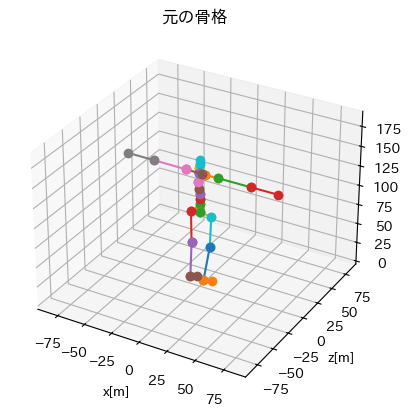

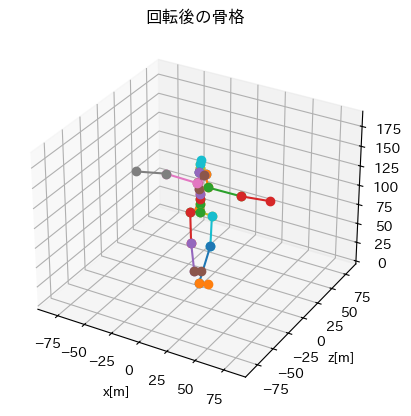

In [6]:
coord = skelton2coords(skeleton)
plot_skeleton(coord, "元の骨格")

rotated_skeleton = rotated_offset(skeleton, motion_frame)
rotated_coord = skelton2coords(rotated_skeleton)
plot_skeleton(rotated_coord, "回転後の骨格")

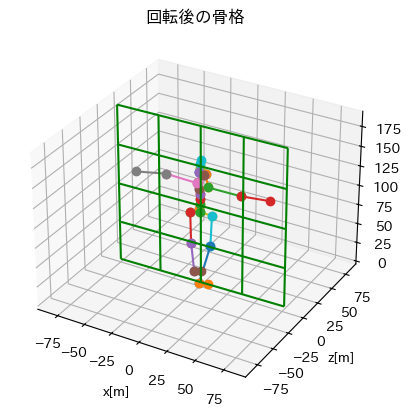

In [7]:
from scipy import linalg
import numpy as np

# %matplotlib qt

points = np.array([j["coord"] for j in rotated_coord.values()])

Xtil = np.c_[
    np.ones(len(points)),
    points[:, 0],
    points[:, 1],
]

A = np.dot(Xtil.T, Xtil)  # 標準形A,bに当てはめる。
b = np.dot(Xtil.T, points[:, 2])
w = linalg.solve(A, b)  # (8)式をwについて解く。

xmesh, ymesh = np.meshgrid(np.linspace(-75, 75, 5), np.linspace(0, 200, 5))
zmesh = (w[0] + w[1] * xmesh.ravel() + w[2] * ymesh.ravel()).reshape(xmesh.shape)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(xmesh, zmesh, ymesh, color="g")
for joint, coord in rotated_coord.items():
    if coord["parent"] == None:
        continue
    parent_coord = rotated_coord[coord["parent"]]["coord"]
    ax.plot(
        [parent_coord[0], coord["coord"][0]],
        [parent_coord[2], coord["coord"][2]],
        [parent_coord[1], coord["coord"][1]],
        marker="o",
    )

plt.title("回転後の骨格")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.ylabel("z[m]")
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.set_zlim(0, 190)

plt.show()